# Analyzing the time series $dW_t$
This notebook is written to test if $W_t$ behaves as Brownian motion. Results are obtained by using the Maps dataset and training as
```
python train.py --name PROJECT --model atme --direction AtoB --dataroot ./datasets/maps --n_save_noisy 5
```
This will generate the folder `./checkpoints/PROJECT/images_noisy` with the history of $D_t$ and $W_t$ for `n_save_noisy` randomly selected images of the train set.

In [3]:
%matplotlib inline
from PIL import Image
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

In [1]:
base_path = 'images_noisy'
n_save_noisy = 5
img_ids = {'452': 0, '536': 1, '575': 2, '690':3, '856': 4}

In [5]:
def normalize(arr):
    # Normalize numpy arr to the range [-1,1]
    arr_min, arr_max = arr.min(), arr.max()
    scaled = (arr - arr_min) / (arr_max - arr_min)
    return 2 * scaled - 1

def epoch_from_img_path(img_path):
    return int(img_path.name.split('_')[1])


def save_dW_time_series(gamma=0.95):
    roll_avg_W = np.zeros((n_save_noisy, 256,256))

    for img_path in sorted(Path(base_path).glob('*_W_*.png'), key=epoch_from_img_path):
        epoch = epoch_from_img_path(img_path)
        id = img_path.stem.split('_')[-1]
        img_W_now = Image.open(img_path).convert('L')
        img_W_now = np.array(img_W_now, dtype=np.float32)
        roll_avg_W[img_ids[id]] = (1-gamma) * roll_avg_W[img_ids[id]] + gamma * img_W_now
        if epoch > 1:
            try:
                img_name_prev = img_path.name.replace(f"epoch_{epoch:03d}", f"epoch_{epoch-1:03d}")
                img_W_prev = Image.open(f'{base_path}/{img_name_prev}').convert('L')
                img_W_prev = np.array(img_W_prev, dtype=np.float32)
            except:
                # If image not found, replace by moving avg
                img_W_prev = roll_avg_W[img_ids[id]]
            
            img_dW = normalize(img_W_now) - normalize(img_W_prev)
            img_dW = 255 * (normalize(img_dW) + 1) / 2
        else:
            img_dW = img_W_now

        cv2.imwrite(f'{base_path}/{img_path.name.replace("W", "dW")}', img_dW.astype(np.uint8))

save_dW_time_series()

In [6]:
def get_dW(id=690):
    dW = np.empty((1,256,256))
    for img_path in sorted(Path(base_path).glob(f'*_dW_{id}.png'), key=epoch_from_img_path):
        # Open image and convert to [-1,1]
        img = normalize(np.array(Image.open(img_path).convert('L'))[None])
        dW = np.concatenate((dW, img), axis=0)
    return dW[1:]

dW_452 = get_dW(id=452)
dW_536 = get_dW(id=536)
dW_575 = get_dW(id=575)
dW_690 = get_dW(id=690)
dW_856 = get_dW(id=856)

Select 5 random pixels for each of the `n_save_noisy` images

In [14]:
pix = np.random.randint(0, 256, (n_save_noisy, n_save_noisy, 2))

### Test for stationarity

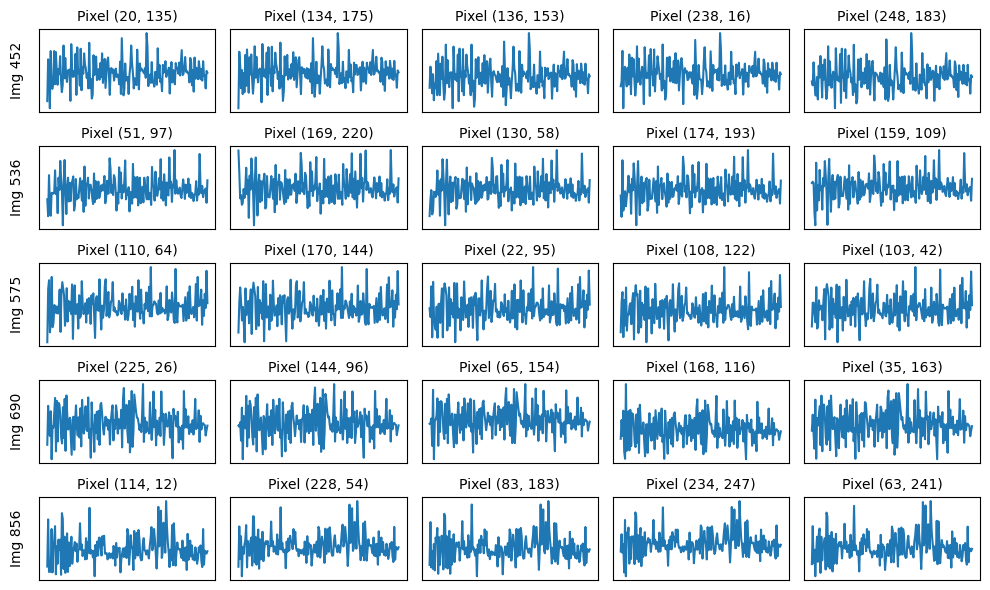

In [15]:
from statsmodels.tsa.stattools import adfuller

def subplot_time_series(data, n_save_noisy, pix, adfuller_p_arr, row=0, ax=None, id=0):
    for n in range(n_save_noisy):
        if n == 0: # row title
            ax[n].set_ylabel(f'Img {id}')
        # Choose pixel to plot
        pix_x, pix_y = pix[img_ids[str(id)], n, 0], pix[img_ids[str(id)], n, 1]
        ax[n].plot(data[:, pix_x, pix_y])
        ax[n].set(yticklabels=[])
        ax[n].set(xticklabels=[])
        ax[n].tick_params(left=False) 
        ax[n].tick_params(bottom=False) 
        ax[n].set_title(f'Pixel ({pix_x}, {pix_y})', fontdict={'fontsize':10})
        adfuller_p_arr[row, n] = adfuller(data[:, pix_x, pix_y])[1]

fig, axs = plt.subplots(5, 5, figsize=(10,6))

adfuller_p_arr = np.empty((n_save_noisy, n_save_noisy)) 

subplot_time_series(dW_452, n_save_noisy, pix, adfuller_p_arr, row=0, ax=axs[0], id=452)
subplot_time_series(dW_536, n_save_noisy, pix, adfuller_p_arr, row=1, ax=axs[1], id=536)
subplot_time_series(dW_575, n_save_noisy, pix, adfuller_p_arr, row=2, ax=axs[2], id=575)
subplot_time_series(dW_690, n_save_noisy, pix, adfuller_p_arr, row=3, ax=axs[3], id=690)
subplot_time_series(dW_856, n_save_noisy, pix, adfuller_p_arr, row=4, ax=axs[4], id=856)
fig.tight_layout()

The $p$-value of the test statistic in the Augmented Dickey-Fuller test is less than 0.01 in all cases, so we reject the null hypothesis that the respective time series are non-stationary.

In [9]:
(adfuller_p_arr < 0.01).all()

True

### Test for normality of $dW_t$

In [16]:
from scipy.stats import shapiro

def normality_test(data, n_save_noisy, pix, normality_p_arr, row=0, id=0):
    for n in range(n_save_noisy):
        pix_x, pix_y = pix[img_ids[str(id)], n, 0], pix[img_ids[str(id)], n, 1]
        normality_p_arr[row, n] = shapiro(data[:, pix_x, pix_y])[1]


normality_p_arr = np.empty((n_save_noisy, n_save_noisy)) 

normality_test(dW_452, n_save_noisy, pix, normality_p_arr, row=0, id=452)
normality_test(dW_536, n_save_noisy, pix, normality_p_arr, row=1, id=536)
normality_test(dW_575, n_save_noisy, pix, normality_p_arr, row=2, id=575)
normality_test(dW_690, n_save_noisy, pix, normality_p_arr, row=3, id=690)
normality_test(dW_856, n_save_noisy, pix, normality_p_arr, row=4, id=856)

np.mean(normality_p_arr > 0.01)

0.64

The $p$-value for the Shapiro-Wilk test is greater than 0.01 in a significant number of cases, so we cannot reject the null hypotheses that the respective time series are normally distributed.

### Test for uncorrelated $dW_t$

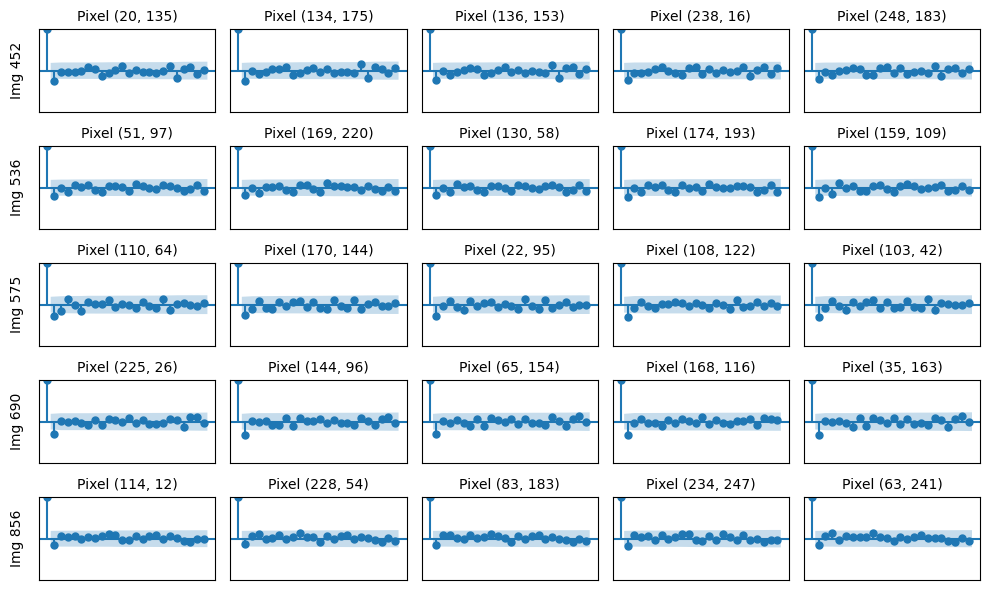

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

def subplot_acf(data, n_save_noisy, pix, ax=None, id=0):
    for n in range(n_save_noisy):
        if n == 0: # row title
            ax[n].set_ylabel(f'Img {id}')
        # Choose pixel to plot
        pix_x, pix_y = pix[img_ids[str(id)], n, 0], pix[img_ids[str(id)], n, 1]
        plot_acf(data[:, pix_x, pix_y], ax=ax[n], title='', alpha=0.01)
        ax[n].set(yticklabels=[])
        ax[n].set(xticklabels=[])
        ax[n].tick_params(left=False) 
        ax[n].tick_params(bottom=False) 
        ax[n].set_title(f'Pixel ({pix_x}, {pix_y})', fontdict={'fontsize':10})

fig, axs = plt.subplots(5, 5, figsize=(10,6))
subplot_acf(dW_452, n_save_noisy, pix, ax=axs[0], id=452)
subplot_acf(dW_536, n_save_noisy, pix, ax=axs[1], id=536)
subplot_acf(dW_575, n_save_noisy, pix, ax=axs[2], id=575)
subplot_acf(dW_690, n_save_noisy, pix, ax=axs[3], id=690)
subplot_acf(dW_856, n_save_noisy, pix, ax=axs[4], id=856)
fig.tight_layout()

Within $99\%$ confidence level, the ACF of $dW_t$ vanishes at all lags for a significant number of cases.

### Save images $D_t$ (re-scaled), $W_t$, and $dW_t$ for GIF

In [7]:
from PIL import Image, ImageDraw, ImageFont

sigmoid = lambda x: 1 / (1 + np.exp(-x))

def concat_D_W_dW_and_save(from_logits=False):
    # Concatenate rescaled D with W and dW
    for img_path in Path(base_path).glob('*_D_*.png'):
        img_D = Image.open(img_path).convert('L')
        if from_logits:
            img_D = sigmoid(normalize(np.array(img_D, dtype=np.float32)))
            img_D = Image.fromarray(255 * (img_D + 1) / 2)
        img_D = img_D.resize((256, 256), resample=Image.NEAREST)
        img_W = Image.open(f'{base_path}/{img_path.name.replace("D", "W")}').convert('L')
        img_dW = Image.open(f'{base_path}/{img_path.name.replace("D", "dW")}').convert('L')
        # Create a new image with a width that is the sum of the widths of the images and a height 
        # that is the maximum of the heights of the images plus the height of the title
        widths, heights = zip(*(i.size for i in [img_D, img_W, img_dW]))
        total_width, max_height = sum(widths), max(heights)
        title_height = 30
        bottom_text_height = 50
        padding = 10
        new_image = Image.new('L', (total_width + padding * 4, max_height + title_height * 3), (255))
        # Create new draw object
        draw = ImageDraw.Draw(new_image)
        # Choose a font and size for the titles
        font_title = ImageFont.truetype('/home/sola_ed/mambaforge/envs/atme/fonts/cmr10.ttf', 20)
        # Write the titles on the new image:
        x_offset = padding
        y_offset = padding + title_height
        titles = [r'D', r'W', r'dW']
        for img in [img_D, img_W, img_dW]:
            title = f'{titles[[img_D, img_W, img_dW].index(img)]}'
            title_width, title_height = draw.textsize(title, font=font_title)
            title_x = x_offset + (img.width - title_width) // 2
            draw.text((title_x, padding), title, font=font_title, fill=(0), align='center', anchor='ma', spacing=5, latex=True)
            new_image.paste(img, (x_offset, y_offset))
            x_offset += img.width + padding
        # Put text at the bottom to denote the current epoch
        font_bottom = ImageFont.truetype('/home/sola_ed/mambaforge/envs/atme/fonts/cmr10.ttf', 20)
        bottom_text = f"Epoch {epoch_from_img_path(img_path)}"
        bottom_text_width, bottom_text_height = draw.textsize(bottom_text, font=font_bottom)
        bottom_text_x = (new_image.width - bottom_text_width) // 2
        bottom_text_y = new_image.height - padding - bottom_text_height
        draw.text((bottom_text_x, bottom_text_y), bottom_text, font=font_bottom, fill=(0))

        # Save image
        new_image.save(f'{base_path}/{img_path.name.replace("D", "DWdW")}')

concat_D_W_dW_and_save(from_logits=True)

In [8]:
import imageio

def create_gif_from_series(id=452):
    images = []
    for img_path in sorted(Path(base_path).glob(f'*_DWdW_{id}.png'), key=epoch_from_img_path):
        images.append(imageio.imread(img_path))
    imageio.mimsave(f'{base_path}/DWdW_{id}.gif', images, duration=200, loop=True)

create_gif_from_series(id=452)
create_gif_from_series(id=536)
create_gif_from_series(id=575)
create_gif_from_series(id=690)
create_gif_from_series(id=856)